<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and visualize the data

In [1]:
# install albumentations and timm (these two libraries are not installed in colab)
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-kr1248u9
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-kr1248u9
     |████████████████████████████████| 47.8 MB 2.6 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=8f7da421a9f5d8d6d0bf51c2a4cc0c72fc293808f06df55b43139ca3fbb06f60
  Stored in directory: /tmp/pip-ephem-wheel-cache-4hhrzhl7/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 431 kB 9.1 MB/s 


In [2]:
# download the dataset
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 9.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [4]:
# import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
import sys
sys.path.append("/content/object-localization-dataset")

In [7]:
data_dir = "/content/object-localization-dataset/"
df = pd.read_csv(data_dir + "train.csv")
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


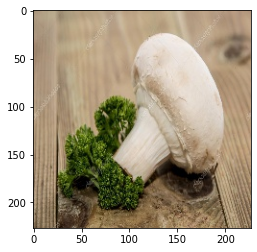

In [8]:
# visualize an image
image = df.iloc[5]
img = cv2.imread(data_dir + image.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

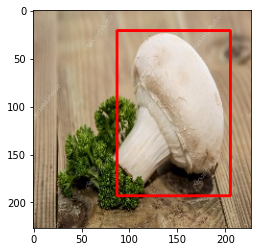

In [9]:
# visualize an image with bounding box
pt1 = (image.xmin, image.ymin)
pt2 = (image.xmax, image.ymax)
b_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0),2)
plt.imshow(b_box_img)

In [10]:
# split the dataset into train and validation datasets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# augment some data using albumentations package
import albumentations as A

data_aug_train = A.Compose([A.Resize(140, 140),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.Rotate()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

data_aug_val = A.Compose([A.Resize(140, 140),], 
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [12]:
# prepare data loaders (combine dataset and sampler)
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Number of batches in train loader: ", len(train_loader))
print("Number of batches in valid loader: ", len(val_loader))

Number of batches in train loader:  10
Number of batches in valid loader:  3


In [13]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [14]:
for img, bbox in train_loader:
  break
print("Shape of one batch images: ", img.get_shape())
print("Shape of one batch bounding box: ", bbox.get_shape())

KeyError: ignored

In [15]:
# create custom dataset
class ObjectLocData(torch.utils.data.Dataset):
  def __init__(self, df, augmentation=None):
    self.df = df
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      image = self.df.iloc[idx]
      xmin = image.xmin
      ymin = image.ymin
      xmax = image.xmax
      ymax = image.ymax

      bbox = [[xmin, ymin, xmax, ymax]]

      image_path = data_dir + image.img_path
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      if self.augmentation:
        data = self.augmentation(image=img, bboxes=bbox, class_labels=[None])
        img = data['image']
        bbox = data['bboxes'][0]

      img = torch.from_numpy(img).premute(2,0,1)/255.0 # (h,w,c) -> (c,h,w)
      bbox = torch.Tensor(bbox)

      return img, bbox

In [17]:
train_data = ObjectLocData(train_data, data_aug_train)
val_data = ObjectLocData(val_data, data_aug_val)

print('Num training images: ', len(train_data))
print('Num test images: ', len(val_data))

Num training images:  148
Num test images:  38


In [22]:
print(type(train_data))

<class '__main__.ObjectLocData'>


In [23]:
# visualize an image
img, bbox = train_data[5]
xmin, ymin, xmax, ymax = bbox
pt1 = [int(xmin), int(ymin)]
pt2 = [int(xmax), int(ymax)]

bbox_img = cv2.rectangle(img.premute(1,2,0).numpy(), pt1, pt2, (255,0,0),2)
plt.imshow(bbox_img)

AttributeError: ignored

## Define a neural network

## Train the model

# Evaluate the performance of our trained model on a test dataset!